# 6.1 Shape descriptors

The main objective of region description is to obtain a mathematical representation of a segmented region from an image consisting of a vector of features $\mathbf{x}=[x_1,\dots,x_n]$.  

<img src="./images/region_description_sample.png" width="450">

In this notebook we will see a branch of region description called **shape analysis**. Shape analysis aims to construct this feature vector using only shape features (e.g., size, perimeter, circularity and compactness).  

Depending on the application, it could be needed that the used descriptor be **invariant** to the position in the image in which the regions appears, its orientation, and/or its size (scale). Some examples:

<img src="./images/invariances.png" width="650">

This notebook **covers simple shape descriptors of regions** based on their area, perimeter, minimal bounding-box, etc (sections 6.1.1 and 6.1.2). We will also study **if these descriptors are invariant to position, orentation and size** (section 6.1.3). Let's go!

## Problem context - Number-plate recognition

So here we are again! UMA called for us to join a team working on their parking access system. This time, they want to upgrade their obsolete number-plate detection algorithm by including better and more efficient methods.  

<img src="./images/access_system.png" width="400">$\\[5pt]$

Here is where our work starts, we are going to **apply shape analysis to each of the characters** that can appear on a license plate, that is, numbers from 0 to 9, and letters in the alphabet. The idea is to **produce a unique feature vector** for each character that could appear on a plate (e.g. $\mathbf{x^0}$, $\mathbf{x^1}$, $\mathbf{x^A}$, $\mathbf{x^B}$, etc.) so it could be later use to **train an automatic classification system** (we will see this in the next chapter!).

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

images_path = './images/'

### Initial data

UMA's parking security team have sent us some segmented plate characters captured by their camera in the parking. They have binarized and cropped these images, providing us with regions representing such characters as white pixels. These cropped images are `region_0.png` (region with a zero), `region_6.png` (region with a six), `region_B.png` (region with a B), and `region_J.png` (region with a J).  

Let's visualize them!

Text(0.5, 1.0, 'Six region')

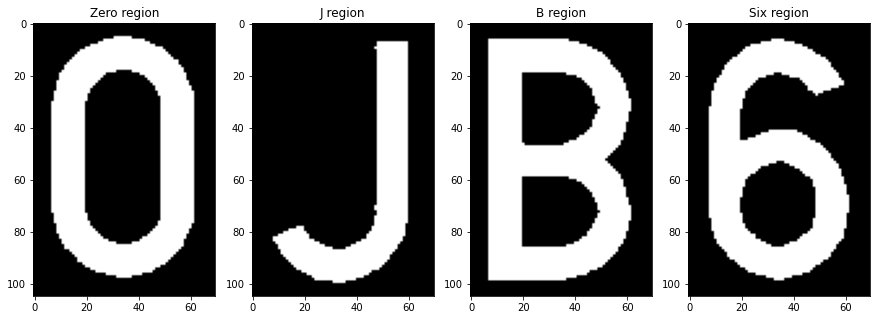

In [2]:
# Read the images
zero = cv2.imread(images_path + 'region_0.png',0)
J = cv2.imread(images_path + 'region_J.png',0)
B = cv2.imread(images_path + 'region_B.png',0)
six = cv2.imread(images_path + 'region_6.png',0)

# And show them!
plt.subplot(141)
plt.imshow(zero, cmap='gray')
plt.title('Zero region')

plt.subplot(142)
plt.imshow(J, cmap='gray')
plt.title('J region')

plt.subplot(143)
plt.imshow(B, cmap='gray')
plt.title('B region')

plt.subplot(144)
plt.imshow(six, cmap='gray')
plt.title('Six region')

## 6.1.1 Compactness

The first feature we are going to work with is **compactness**:$\\[5pt]$

$$\textbf{compactness} = \frac{area}{perimeter^2}$$$\\[5pt]$

As you can see, this feature associates the area with the permeter of a region. Informally, it tells how *rounded* and *closed* is a region. The most compact shape is the circle, with $\textbf{compactness} = 1 / (4\pi)$.

<img src="./images/compactness.png" width="300">$\\[5pt]$

#### <font color="orange">OpenCV pill</font>
    
OpenCV uses contours for analysing shapes. A contour is a list of points that defines a region. We can obtain the contours of a region using [`cv2.findContours()`](https://docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0). 

### **<span style="color:green"><b><i>ASSIGNMENT 1: Computing compactness</i></b></span>**

**What to do?** Complete the function bellow, named `compactness()`, which computes the compactness of an input region.

For that, we are going to use the [`cv2.findContours()`](https://docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0) function, which takes as input:

- A binary image (containing the region as white pixels).
- Contour retrieval mode, it can be:$\\[5pt]$
    - `RETR_EXTERNAL`: only returns the external contour
    - `RETR_LIST`: returns all contours (e.g. the character 0 would contain two contours: external and internal)
    - `RETR_CCOMP`: returns all contours and organize them in a two-level hierarchy. At the top level, there are external boundaries of the components. At the second level, there are boundaries of the holes.$\\[5pt]$
- Method: controls how many points of the contours are being stored, this is for optimization purposes.$\\[5pt]$
    - `CHAIN_APPROX_NONE`: stores absolutely all the contour points.
    - `CHAIN_APPROX_SIMPLE`: compresses horizontal, vertical, and diagonal segments and leaves only their end points. 
    - `CHAIN_APPROX_TC89_L1`: applies an optimization algorithm.
    
And returns: 

- a list containing the contours,
- and a list containing information about the image topology. It has as many elements as the number of contours. 

For simplicity, we are going to take into account **only the external boundary** (as if the regions have not holes), so the second output is not relevant.  

Having the contours, you can obtain the **area** and the **perimeter** of the region through [`cv2.contourArea()`](https://docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#ga2c759ed9f497d4a618048a2f56dc97f1) and [`cv2.arcLength()`](https://docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#ga8d26483c636be6b35c3ec6335798a47c). Both functions take the contours of the region as input.

In [3]:
# Assignment 1
def compactness(region):
    """ Compute the compactness of a region.   
    
        Args:
            region: Binary image
                    
        Returns: 
            compactness: Compactness of region (between 0 and 1/4pi)
    """   
    
    # Get external contour
    contours,_ = cv2.findContours(region,cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_NONE)
    cnt = contours[0]
    
    # Calcule area
    area = cv2.contourArea(cnt)

    # Calcule perimeter
    perimeter = cv2.arcLength(cnt,True)

    # Calcule compactness
    compactness = area/perimeter**2

    return compactness

You can use next code to **test if the results are right**:

In [4]:
# Read the images
zero = cv2.imread(images_path + 'region_0.png',0)
J = cv2.imread(images_path + 'region_J.png',0)
B = cv2.imread(images_path + 'region_B.png',0)
six = cv2.imread(images_path + 'region_6.png',0)

# And show their compactness!
print(" Compactness of 0: ", round(compactness(zero),5), "\n",
      "Compactness of J: ", round(compactness(J),5), "\n",
      "Compactness of B: ", round(compactness(B),5), "\n",
      "Compactness of 6: ", round(compactness(six),5))

 Compactness of 0:  0.06588 
 Compactness of J:  0.01815 
 Compactness of B:  0.05675 
 Compactness of 6:  0.02876


<font color='blue'>**Expected output  </font> (using `CHAIN_APPROX_NONE`):**

    Compactness of 0:  0.06588 
    Compactness of J:  0.01815 
    Compactness of B:  0.05675 
    Compactness of 6:  0.02876

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Excellent! Now, **answer the following questions:**

- Why `region_0.png` have the greatest compactness?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- Could we differentiate all characters using only this feature as feature vector?
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>   
    
- Is compactness invariant to position, orientation or scale?

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>   

## 6.1.2 Extent

Another shape descriptor is **extent** of a shape:$\\[5pt]$

$$\textbf{extent} = \frac{area}{bounding\ rectangle\ area}$$$\\[5pt]$

This feature associates the area of the region with the area its bounding rectangle. A **bounding rectangle** can be defined as the minimum rectangle that contains all the pixels of a region whose bottom edge is horizontal and its left edge is vertical.

<img src="./images/bounding.png" width="400">

The shape with the highest extent value is the rectangle, with $extent=1$, while the lowest one is an empty region so $extent=0$.

### **<span style="color:green"><b><i>ASSIGNMENT 2: Time to compute the extent</i></b></span>**

Complete the function `extent()`, which receives the `region` to be described as input and returns its `extent`.

*Tip: compute the bounding rectangle using [cv2.boundingRect()](https://docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#ga103fcbda2f540f3ef1c042d6a9b35ac7), which also takes the contours as input.*

In [5]:
def extent(region):
    """ Compute the extent of a region.   
    
        Args:
            region: Binary image
                    
        Returns: 
            extent: Extent of region (between 0 and 1)
    """   
    
    # Get external contour
    contours,_ = cv2.findContours(region,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
    cnt = contours[0]
    
    # Calcule area
    area = cv2.contourArea(cnt)
    
    # Get bounding rectangle
    _,_,w,h = cv2.boundingRect(cnt)
    
    # Calcule bounding rectangle area
    rect_area = w*h
    
    # Calcule extent
    extent = float(area)/rect_area
    
    return extent

You can use next code to **test if the obtained results are correct**:

In [6]:
# Read the images
zero = cv2.imread(images_path + 'region_0.png',0)
J = cv2.imread(images_path + 'region_J.png',0)
B = cv2.imread(images_path + 'region_B.png',0)
six = cv2.imread(images_path + 'region_6.png',0)

# And show their extent!
print("Extent of 0: ", round(extent(zero),5), "\n",
      "Extent of J: ", round(extent(J),5), "\n",
      "Extent of B: ", round(extent(B),5), "\n",
      "Extent of 6: ", round(extent(six),5))

Extent of 0:  0.84203 
 Extent of J:  0.2866 
 Extent of B:  0.87937 
 Extent of 6:  0.64068


<font color='blue'>**Expected output  </font> (using `CHAIN_APPROX_NONE`):**

    Extent of 0:  0.84203 
    Extent of J:  0.2866 
    Extent of B:  0.87937 
    Extent of 6:  0.64068

### <font color="blue"><b><i>Thinking about it (2)</i></b></font>

Now, **answer the following questions:**

- Why `region_B.png` have the greatest compactness?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- Is extent invariant to position, orientation or scale? If not, how could we turn it into a invariant feature?
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>   

## 6.1.3 Building a feature vector

Now that we can compute two different features, compactness ($x_1$) and extent ($x_2$), we can build a feature vector ($\mathbf{x}$) for characterizing each region by concatenating both features, that is, $\mathbf{x}=[x_1,x_2]$.

Before sending to UMA our solution for region description, let's see if these features are discriminative enough to differentiate between the considered characters. 

### **<span style="color:green"><b><i>ASSIGNMENT 3: Plotting feature vectors</i></b></span>**

**You task is** to plot the feature vectors, computed by the functions `compactness()`and `extent()`, in a 2D-space. In such a space, the **x-axis represents the compactness** of a region and the **y-axis its extent**.

In this way, if the descriptions of the considered characters in this space don't appear close to each other, that means that they can be differentiated by relying on those features. **The problem appears if two or more characters have similar features** (their respective points are near). This tell us that **those features are just not enough** for automatically detect the plate characters.

*Tip: [intro to pyplot](https://matplotlib.org/tutorials/introductory/pyplot.html)*.

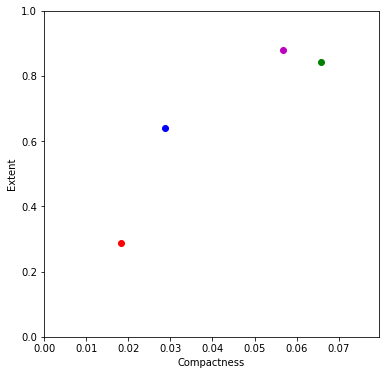

In [7]:
# Assignment 3
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

# Read the images
zero = cv2.imread(images_path + 'region_0.png',0)
J = cv2.imread(images_path + 'region_J.png',0)
B = cv2.imread(images_path + 'region_B.png',0)
six = cv2.imread(images_path + 'region_6.png',0)

# Build the feature vectors
x_zero = np.array([compactness(zero), extent(zero)])
x_J = np.array([compactness(J), extent(J)]) 
x_B = np.array([compactness(B), extent(B)]) 
x_six = np.array([compactness(six), extent(six)])

# Define the scatter plot
fig, ax = plt.subplots()
plt.axis([0, 1/(4*np.pi), 0, 1])
plt.xlabel("Compactness")
plt.ylabel("Extent")

# Plot the points
plt.plot(x_zero[0], x_zero[1], 'go')
plt.plot(x_J[0], x_J[1], 'ro')
plt.plot(x_B[0], x_B[1], 'mo')
plt.plot(x_six[0], x_six[1], 'bo')

### <font color="blue"><b><i>Thinking about it (3)</i></b></font>

**What do you think?**

- Are they discriminative enough?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
     
- If your answer is no, how could we handle this problem?
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>   

## Conclusion

Great work! You have learned about:
- what is the aim of region descriptors, 
- the ideas behind two simple shape descriptors: compactness and extent, and
- to build a vector of features and analyze its discriminative power. 

Unfortunately, it seems that those two features are not enough to differentiate the plate characters, so let's try more complex descriptors in the next notebook!  

## Extra work

Surf the internet looking for **more shape features**, and try to find a pair of them working better than compactness and extent.  